In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL as image_lib
from PIL import Image, ImageOps
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import glob
import os
import tqdm

2023-04-05 01:16:40.529368: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 01:16:43.809051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-05 01:16:43.810267: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 01:16:48.770166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Relabeled Data

### Sample Image

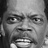

In [3]:
# loading a sample image
sample_image = Image.open("/workspaces/awesome-group/00_source_data/train_relabeled/01_Angry/10.jpg")
sample_image

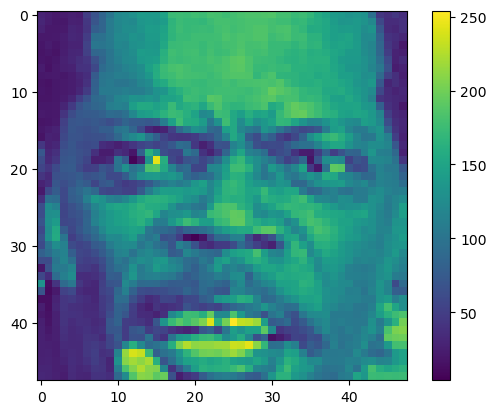

In [4]:
plt.imshow(sample_image)
plt.colorbar()

### Extracting only face from the images

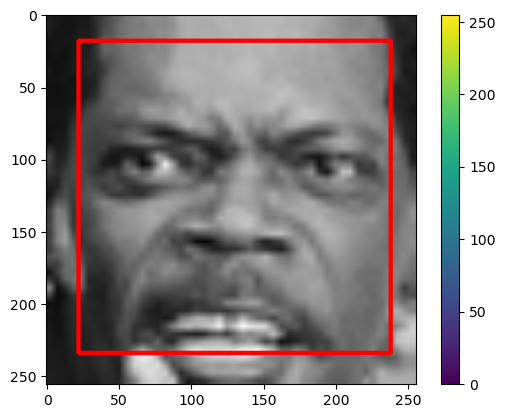

In [2]:
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/workspaces/awesome-group/00_source_data/train_relabeled/01_Angry/10.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
plt.imshow(img)
plt.colorbar()
plt.show()

### Applying extract to all images

In [4]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [5]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)
     

### Focusing on the face and preparing x_data and y_data

In [ ]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/train_relabeled
emo_types = ['01_Angry', '02_Disgust', '03_Fear', '04_Happy', '05_Neutral', '06_Bad', '07_Surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-group/00_source_data/train_relabeled', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [7]:
# Check x_data and y_data shapes
print(np.array(x_data).shape)
print(np.array(y_data).shape)

(8691, 200, 200)
(8691,)


In [8]:
for i,img in enumerate(x_data):
  if len(img.shape) == 3:
    x_data[i] = img.sum(axis=2)

(6952, 200, 200, 1) (6952, 7)
(1739, 200, 200, 1) (1739, 7)


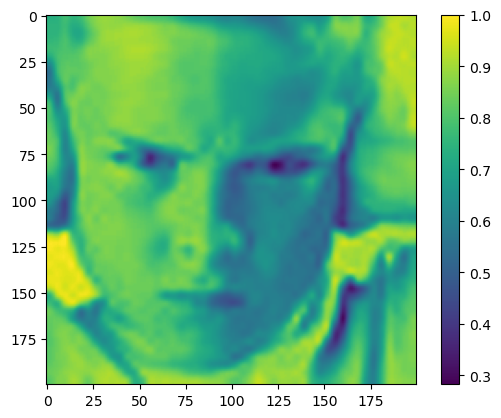

In [13]:
from sklearn.model_selection import StratifiedKFold
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()

# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()
plt.show()

### Train and Fit Model

In [34]:
# Train and fit the model
resnet_50 = tflow.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet_50.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [35]:
# callback
callback = tflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [36]:
# compile the model
resnet_50.compile(optimizer=tflow.keras.optimizers.legacy.Adam(learning_rate=0.001), loss=tflow.keras.losses.CategoricalCrossentropy(),
                        metrics=tflow.keras.metrics.CategoricalAccuracy())

In [37]:
# fit the model using GPU
epochs = 50
history = resnet_50.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[callback], )

Epoch 1/50


2023-04-04 02:40:49.119633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-04 02:40:49.745765: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-04 02:40:49.746238: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-04 02:40:49.746290: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-04 02:40:49.746728: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-04 02:40:49.746810: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

594/594 [==============================] - 69s 103ms/step - loss: 1.6240 - categorical_accuracy: 0.3597 - val_loss: 2.7333 - val_categorical_accuracy: 0.3182
Epoch 2/50
594/594 [==============================] - 59s 99ms/step - loss: 1.3208 - categorical_accuracy: 0.4852 - val_loss: 2.0404 - val_categorical_accuracy: 0.3465
Epoch 3/50
594/594 [==============================] - 59s 99ms/step - loss: 1.1468 - categorical_accuracy: 0.5603 - val_loss: 1.2738 - val_categorical_accuracy: 0.5134
Epoch 4/50
594/594 [==============================] - 59s 99ms/step - loss: 1.0604 - categorical_accuracy: 0.5942 - val_loss: 1.3174 - val_categorical_accuracy: 0.5121
Epoch 5/50
594/594 [==============================] - 59s 99ms/step - loss: 0.9963 - categorical_accuracy: 0.6201 - val_loss: 1.9726 - val_categorical_accuracy: 0.3286
Epoch 6/50
594/594 [==============================] - 59s 99ms/step - loss: 0.9828 - categorical_accuracy: 0.6310 - val_loss: 1.2719 - val_categorical_accuracy: 0.5296
Ep

### Saving the model

In [56]:
# save the model
resnet_50.save('/workspaces/awesome-group/05_clean_data/resnet_50.h5')

### Plotting Training Validation Loss and Accuracy

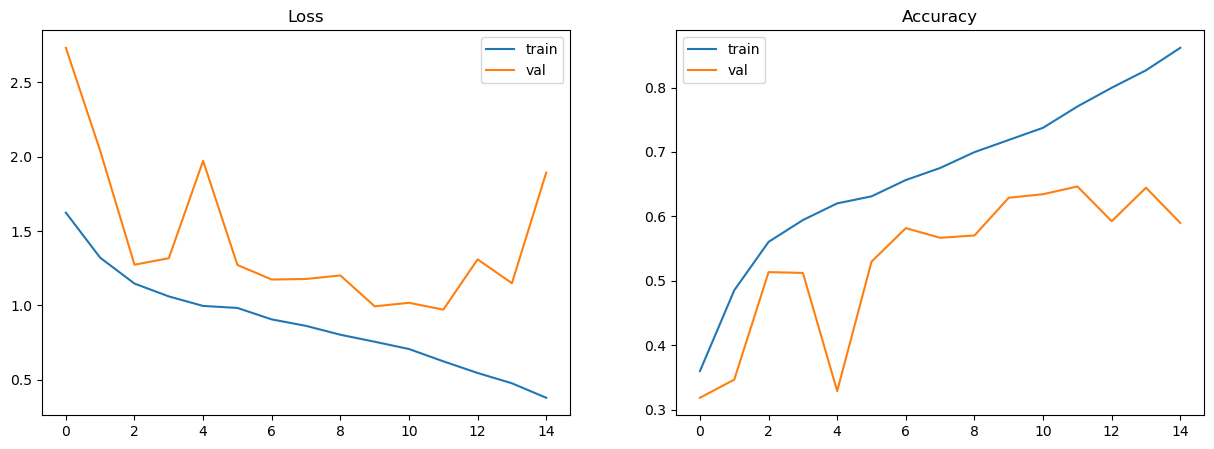

In [40]:
# plot the loss and accuracy in ax[0] and ax[1] respectively
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['categorical_accuracy'], label='train')
ax[1].plot(history.history['val_categorical_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()


### Plotting Saliency Map

In [49]:
# load the model
resnet_50 = tflow.keras.models.load_model('/workspaces/awesome-group/05_clean_data/resnet_50.h5')

1/1 [==============================] - 0s 68ms/step


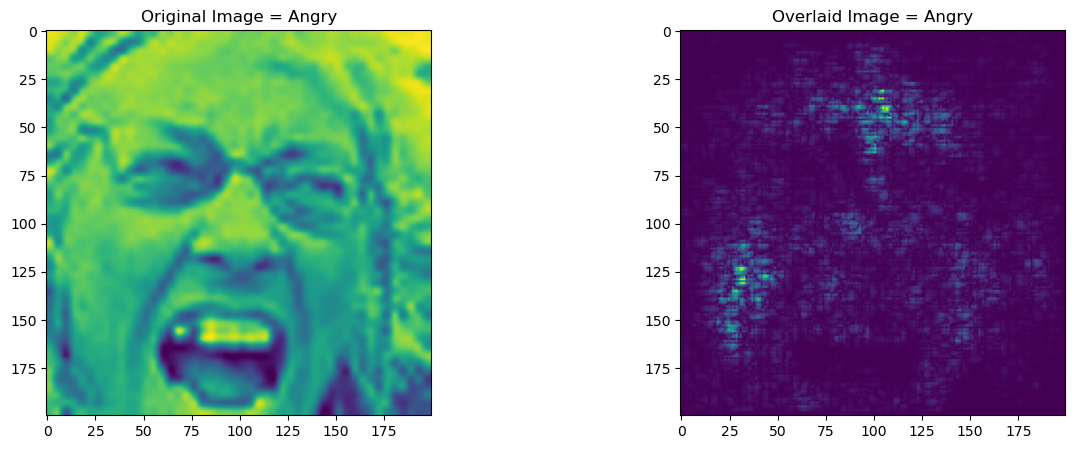

In [57]:
# create saliency map for one image from the angry folder in validation_relabeled folder
img = load_normalize('/workspaces/awesome-group/00_source_data/validation_relabeled/01_Angry/1235.jpg')
img = img.reshape(-1, 200, 200, 1)
img = tflow.convert_to_tensor(img)

# create a function to get the saliency map
def get_saliency_map(img, model):
    with tflow.GradientTape() as tape:
        tape.watch(img)
        pred = model(img)
        loss = pred[:, 0]
    # get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, img)
    # get the absolute values of the gradients
    abs_grads = tflow.abs(gradient)
    # get the maximum value in each dimension (row, column, channel)
    max_val = tflow.reduce_max(abs_grads, axis=(1, 2, 3))
    # get the saliency map by normalizing the gradients with the maximum value
    saliency_map = abs_grads / max_val[:, None, None, None]
    return saliency_map

# get the saliency map
saliency_map = get_saliency_map(img, resnet_50)

# overlay the saliency map on the original image
def overlay_saliency_map(img, saliency_map):
    # get the original image
    original_img = img[0]
    # get the saliency map
    saliency_map = saliency_map[0]
    # resize the saliency map to the size of the original image
    saliency_map = tflow.image.resize(saliency_map, (200, 200))
    # make the saliency map 50% transparent
    saliency_map = saliency_map
    # overlay the saliency map on the original image
    overlaid_img = original_img * saliency_map
    return overlaid_img

# get the overlaid image
overlaid_img = overlay_saliency_map(img, saliency_map)

# change the overlaid image to numpy array
overlaid_img = overlaid_img.numpy()

# The label of original image
pred = resnet_50.predict(img)
pred = np.argmax(pred)
pred_name = emo_types[pred]
# keep only words after the underscore
pred_name = pred_name.split('_')[1]

# plot the original image and the overlaid image with each prediction
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img[0,:,:,0])
ax[0].set_title('Original Image = Angry')
ax[1].imshow(overlaid_img)
# set the transparency of the overlaid image
ax[1].set_alpha(0.1)
ax[1].set_title('Overlaid Image = ' + pred_name)
plt.show()


# Relabeled_cleaned data

In [41]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/train_relabeled
emo_types = ['01_Angry', '02_Disgust', '03_Fear', '04_Happy', '05_Neutral', '06_Bad', '07_Surprise']
emo_inds = np.arange(0, len(emo_types))
x_data_rr = []
y_data_rr = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-group/00_source_data/train_relabeled', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data_rr += [load_normalize(image_path) for image_path in all_images]
    y_data_rr += [emo_ind]*len(all_images)

In [43]:
for i, img in enumerate(x_data_rr):
  if len(img.shape) == 3:
    x_data_rr[i] = img.sum(axis=2)

(18980, 200, 200, 1) (18980, 7)
(4745, 200, 200, 1) (4745, 7)


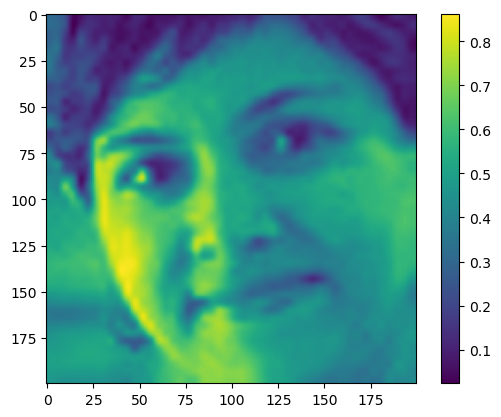

In [44]:
from sklearn.model_selection import StratifiedKFold
# adding a fake color channel
x_data_rr = np.array(x_data_rr).reshape(-1, 200, 200, 1)
y_data_rr = np.array(y_data_rr)

folder = StratifiedKFold(5, shuffle=True)
x_indices_rr = np.arange(0, len(x_data_rr))
train_indices_rr, val_indices_rr = folder.split(x_indices_rr, y_data_rr).__next__()

# shuffling
np.random.shuffle(train_indices_rr)

x_train_rr = x_data_rr[train_indices_rr]
y_train_rr = np.eye(len(emo_types))[y_data_rr[train_indices_rr]]

x_val_rr = x_data_rr[val_indices_rr]
y_val_rr = np.eye(len(emo_types))[y_data_rr[val_indices_rr]]

print(x_train_rr.shape, y_train_rr.shape)
print(x_val_rr.shape, y_val_rr.shape)

plt.imshow(x_train_rr[0,:,:,0])
plt.colorbar()
plt.show()

In [45]:
# Train and fit the model
resnet_50_rr = tflow.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train_rr[0].shape, pooling=None, classes=7)
# model summary
resnet_50_rr.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [46]:
# callback
callback = tflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [47]:
# compile the model
resnet_50_rr.compile(optimizer=tflow.keras.optimizers.legacy.Adam(learning_rate=0.001), loss=tflow.keras.losses.CategoricalCrossentropy(),
                        metrics=tflow.keras.metrics.CategoricalAccuracy())

In [48]:
# fit the model using GPU
epochs = 50
history_rr = resnet_50_rr.fit(x_train_rr, y_train_rr, validation_data=(x_val_rr, y_val_rr), epochs=epochs, callbacks=[callback], )

Epoch 1/50
594/594 [==============================] - 66s 101ms/step - loss: 1.6399 - categorical_accuracy: 0.3458 - val_loss: 3.2657 - val_categorical_accuracy: 0.3182
Epoch 2/50
594/594 [==============================] - 59s 99ms/step - loss: 1.2875 - categorical_accuracy: 0.5009 - val_loss: 2.1503 - val_categorical_accuracy: 0.2786
Epoch 3/50
594/594 [==============================] - 59s 99ms/step - loss: 1.1559 - categorical_accuracy: 0.5534 - val_loss: 1.3318 - val_categorical_accuracy: 0.4746
Epoch 4/50
594/594 [==============================] - 59s 99ms/step - loss: 1.0718 - categorical_accuracy: 0.5914 - val_loss: 2.4873 - val_categorical_accuracy: 0.3357
Epoch 5/50
594/594 [==============================] - 59s 99ms/step - loss: 0.9879 - categorical_accuracy: 0.6247 - val_loss: 1.8232 - val_categorical_accuracy: 0.3941
Epoch 6/50
594/594 [==============================] - 59s 99ms/step - loss: 0.9330 - categorical_accuracy: 0.6440 - val_loss: 1.2750 - val_categorical_accuracy

In [57]:
# save the model
resnet_50_rr.save('/workspaces/awesome-group/05_clean_data/resnet_50_rr.h5')

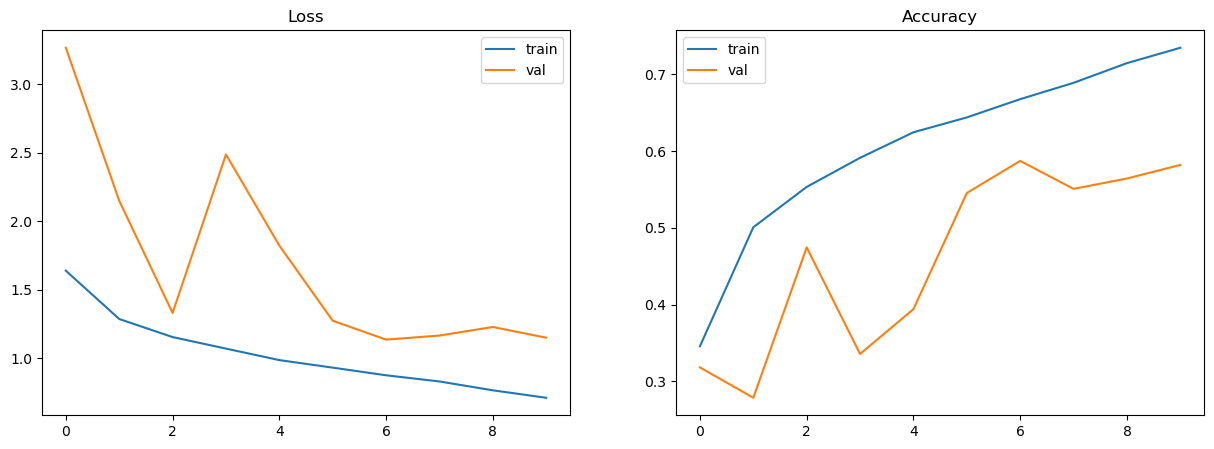

In [55]:
# plot the loss and accuracy in ax[0] and ax[1] respectively
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_rr.history['loss'], label='train')
ax[0].plot(history_rr.history['val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history_rr.history['categorical_accuracy'], label='train')
ax[1].plot(history_rr.history['val_categorical_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

### Creating Saliency Map

In [14]:
# load the model
resnet_50_rr = tflow.keras.models.load_model('/workspaces/awesome-group/05_clean_data/resnet_50_rr.h5')

2023-04-05 01:18:41.718165: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [29]:
# create saliency map for one image from the happy folder in validation_relabeled folder
img = load_normalize('/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned/04_Happy/187.jpg')
img = img.reshape(1, 200, 200, 1)
# predict the image
pred = resnet_50_rr.predict(img)
# get the index of the highest probability
pred = np.argmax(pred)
# get the class name
emo_types[pred]


1/1 [==============================] - 1s 1s/step


'04_Happy'

> Plotting original image and saliency map

1/1 [==============================] - 0s 75ms/step


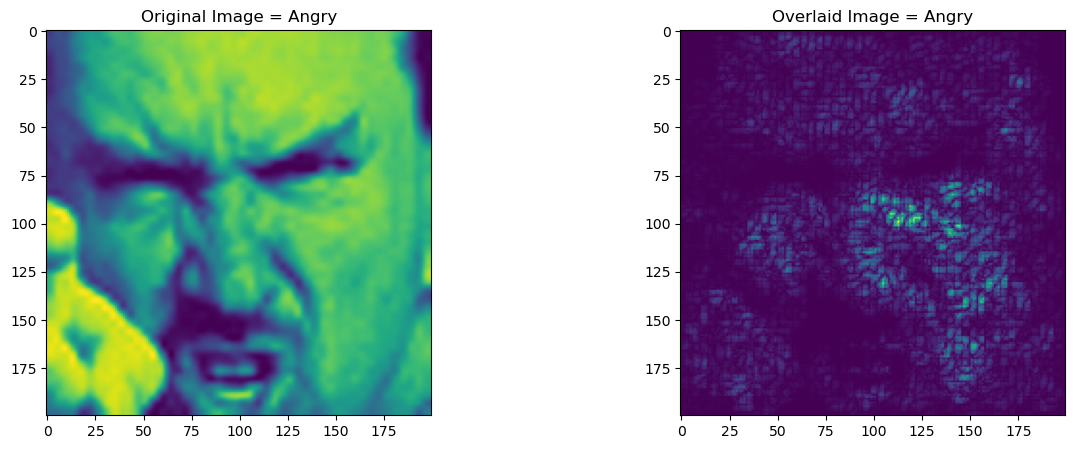

In [58]:
# create saliency map for one image from the angry folder in validation_relabeled folder
img = load_normalize('/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned/01_Angry/3137.jpg')
img = img.reshape(-1, 200, 200, 1)
img = tflow.convert_to_tensor(img)

# create a function to get the saliency map
def get_saliency_map(img, model):
    with tflow.GradientTape() as tape:
        tape.watch(img)
        pred = model(img)
        loss = pred[:, 0]
    # get the gradients of the loss w.r.t to the input image
    gradient = tape.gradient(loss, img)
    # get the absolute values of the gradients
    abs_grads = tflow.abs(gradient)
    # get the maximum value in each dimension (row, column, channel)
    max_val = tflow.reduce_max(abs_grads, axis=(1, 2, 3))
    # get the saliency map by normalizing the gradients with the maximum value
    saliency_map = abs_grads / max_val[:, None, None, None]
    return saliency_map

# get the saliency map
saliency_map = get_saliency_map(img, resnet_50_rr)

# overlay the saliency map on the original image
def overlay_saliency_map(img, saliency_map):
    # get the original image
    original_img = img[0]
    # get the saliency map
    saliency_map = saliency_map[0]
    # resize the saliency map to the size of the original image
    saliency_map = tflow.image.resize(saliency_map, (200, 200))
    # overlay the saliency map on the original image
    overlaid_img = saliency_map * original_img
    return overlaid_img

# get the overlaid image
overlaid_img = overlay_saliency_map(img, saliency_map)

# change the overlaid image to numpy array
overlaid_img = overlaid_img.numpy()

# The label of original image
pred = resnet_50_rr.predict(img)
pred = np.argmax(pred)
pred_name = emo_types[pred]
# keep only words after the underscore
pred_name = pred_name.split('_')[1]

# plot the original image and the overlaid image with each prediction
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(img[0,:,:,0])
ax[0].set_title('Original Image = Angry')
ax[1].imshow(overlaid_img)
# set the transparency of the overlaid image
ax[1].set_alpha(0.1)
ax[1].set_title('Overlaid Image = ' + pred_name)
plt.show()
